<a href="https://colab.research.google.com/github/abbyambita/pneumonia_detection/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
!ls  '/content/drive/My Drive/cs239/'

checkpoint.pth			  test.ipynb	 two_classes_downsampled
densenet121.ipynb		  three_classes  two_classes_upsampled
resnet-1024-256-2-91accuracy.pth  two_classes	 Untitled0.ipynb


In [0]:
from __future__ import print_function, division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists

plt.ion()

In [0]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

cuda:0
CUDA is available!  Training on GPU ...


In [0]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight    

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
                                 transforms.Resize((224, 224)),   
                                 transforms.CenterCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'val': transforms.Compose([
                                 transforms.Resize((224, 224)),                                       
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'test': transforms.Compose([
                                 transforms.Resize((224, 224)),                                       
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
}

data_dir = '/content/drive/My Drive/cs239/two_classes/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

weights = make_weights_for_balanced_classes(image_datasets['train'].imgs, len(image_datasets['train'].classes))                                                                
weights = torch.DoubleTensor(weights)  
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in [ 'val', 'test']}

dataloaders.update({'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size=4,
                                                           sampler = sampler, num_workers=4, pin_memory=True)} )

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

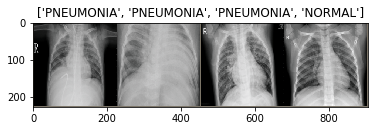

In [69]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
# Build and train your network
# 1. Load resnet-152 pre-trained network
model = models.resnet152(pretrained=True)
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False


In [0]:
# 2. Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout

# Our input_size matches the in_features of pretrained model


from collections import OrderedDict


# Creating the classifier ordered dictionary first

#original dropout parameter: 0.2
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('dp1', nn.Dropout(0.2)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 256)),
                          ('relu2', nn.ReLU()),
                          ('fc3', nn.Linear(256, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

#classifier = nn.Sequential(OrderedDict([
#                          ('fc1', nn.Linear(2048, 1024)),
#                          ('dp1', nn.Dropout(0.3)),
#                          ('relu', nn.ReLU()),
#                          ('fc2', nn.Linear(1024, 256)),
#                          ('relu2', nn.ReLU()),
#                          ('fc3', nn.Linear(256, 2)),
#                          ('output', nn.LogSoftmax(dim=1))
#                          ]))

#classifier = nn.Sequential(OrderedDict([
#                                        ('fcl1', nn.Linear(1024,256)),
#                                        ('dp1', nn.Dropout(0.3)),
#                                        ('r1', nn.ReLU()),
#                                        ('fcl2', nn.Linear(256,32)),
#                                        ('dp2', nn.Dropout(0.3)),
#                                        ('r2', nn.ReLU()),
#                                        ('fcl3', nn.Linear(32,2)),
#                                        ('out', nn.LogSoftmax(dim=1))
#                                        ]))


# Replacing the pretrained model classifier with our classifier
model.fc = classifier

In [0]:
train_losses = []
test_losses = []

#remove scheduler

#def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
def train_model(model, criterion, optimizer, num_epochs=3):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
              train_losses.append(epoch_loss)
            else:
              test_losses.append(epoch_loss)

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [73]:
#Train a model with a pre-trained network
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()
#criterion = nn.CrossEntropyLoss()


 #Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
#optimizer = optim.SGD(model.fc.parameters(), lr = 0.0001, momentum=0.9)
# Decay LR by a factor of 0.1 every 5 epochs

#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


#model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=3)

model_ft = train_model(model, criterion, optimizer, num_epochs=3)

Using GPU: True
Epoch 1/3
----------
train Loss: 0.3880 Acc: 0.8331
test Loss: 0.3095 Acc: 0.8878

Epoch 2/3
----------
train Loss: 0.3544 Acc: 0.8509
test Loss: 0.3574 Acc: 0.8718

Epoch 3/3
----------
train Loss: 0.3302 Acc: 0.8650
test Loss: 0.3159 Acc: 0.8734

Training complete in 9m 10s
Best valid accuracy: 0.887821


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

def evaluate_performance(labels, preds):
  label = ['normal', 'pneumonia']
  #print(confusion_matrix)
  conf_matrix = confusion_matrix(labels, preds)
  print(conf_matrix)

  # Per-class accuracy
  class_accuracy=100*conf_matrix.diagonal()/conf_matrix.sum(1)
  print(class_accuracy)

  print("Accuracy score:", accuracy_score(labels, preds))
  print(classification_report(labels, preds))

  plt.figure()
  plot_confusion_matrix(conf_matrix, classes=['Normal', 'Pneumonia'],
                      title='Confusion matrix')
  plt.show()

In [0]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
  
  nb_classes = 2

  #confusion_matrix = torch.zeros(nb_classes, nb_classes)
  predlist = torch.zeros(0, dtype = torch.long, device = 'cpu')
  labellist = torch.zeros(0, dtype = torch.long, device = 'cpu')


  for images, labels in dataloaders['test']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

    _, preds = torch.max(output, 1)
    # for t, p in zip(labels.view(-1), preds.view(-1)):
    #   confusion_matrix[t.long(), p.long()] += 1
    predlist=torch.cat([predlist,preds.view(-1).cpu()])
    labellist = torch.cat([labellist, labels.view(-1).cpu()])

    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))

  evaluate_performance(labellist.numpy(), predlist.numpy())

Testing Accuracy: 0.021
Testing Accuracy: 0.043
Testing Accuracy: 0.067
Testing Accuracy: 0.091
Testing Accuracy: 0.115
Testing Accuracy: 0.138
Testing Accuracy: 0.162
Testing Accuracy: 0.181
Testing Accuracy: 0.205
Testing Accuracy: 0.231
Testing Accuracy: 0.253
Testing Accuracy: 0.279
Testing Accuracy: 0.301
Testing Accuracy: 0.325
Testing Accuracy: 0.351
Testing Accuracy: 0.375
Testing Accuracy: 0.397
Testing Accuracy: 0.420
Testing Accuracy: 0.442
Testing Accuracy: 0.465
Testing Accuracy: 0.487
Testing Accuracy: 0.510
Testing Accuracy: 0.530
Testing Accuracy: 0.551
Testing Accuracy: 0.575
Testing Accuracy: 0.598
Testing Accuracy: 0.622
Testing Accuracy: 0.646
Testing Accuracy: 0.667
Testing Accuracy: 0.688
Testing Accuracy: 0.713
Testing Accuracy: 0.739
Testing Accuracy: 0.763
Testing Accuracy: 0.787
Testing Accuracy: 0.809
Testing Accuracy: 0.833
Testing Accuracy: 0.854
Testing Accuracy: 0.877
Testing Accuracy: 0.901
[[196  38]
 [ 24 366]]
[83.76068376 93.84615385]
Accuracy score:

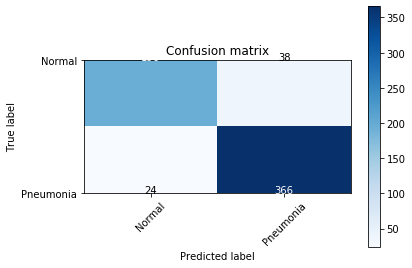

In [0]:
test(model, dataloaders, device)

In [0]:
# Save the checkpoint 
num_epochs = 30
model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [2, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size':2,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, '/content/drive/My Drive/cs239/resnet-1024-256-2-91accuracy.pth')

In [0]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    # our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 2
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(1024, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))


    # Replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# Get index to class mapping
loaded_model, class_to_idx = load_checkpoint('90_checkpoint.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

In [0]:

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
visualize_model(model_ft)

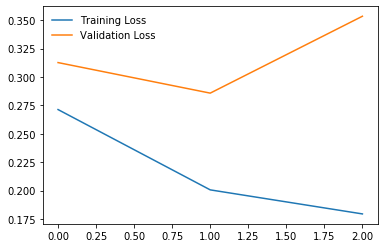

In [0]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=False)